## Text-Based Ad Feedback Topic Modeling: EDA<br>

### TOC
* [Step 1: Load Data & Formatting](#1)
* [Step 2: EDA of Sample Distribution](#2)
* [Step 3: Tokenize & Remove Stopwords](#3)
* [Step 4: Lemmatize](#4)
* [Step 5: Term Frequency Analysis](#5)
* [Step 6: Sentiment Analysis](#6)
* [Step 7: Summary & Next Steps](#7)

### Step 1: Load Data and Formatting   <a class="anchor" id="1"></a>

In [1]:
#Load Packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from textblob import TextBlob
from wordcloud import WordCloud, ImageColorGenerator
import re
import spacy
import en_core_web_sm
from spacy.tokenizer import Tokenizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)
from nltk.probability import FreqDist
import qgrid
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Open data
clean_df = pd.read_csv('../Datafiles/Feedback_df_clean.csv')

In [3]:
#Inspect raw feedback file
print(clean_df.info())
clean_df.sort_values(by='Text_Clean')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             1448 non-null   object
 1   Text_Original  1448 non-null   object
 2   Ad             1448 non-null   object
 3   Age            1448 non-null   int64 
 4   Race           1448 non-null   object
 5   Segment        1448 non-null   int64 
 6   Urban          1448 non-null   int64 
 7   Female         1448 non-null   int64 
 8   Region_1       1448 non-null   int64 
 9   Text_Clean     1448 non-null   object
dtypes: int64(5), object(5)
memory usage: 113.2+ KB
None


,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean
0,R_31EnmC82PmXgfeJ,A lot of chemicals are in vapes that damage th...,DF,17,White Only,1,1,0,1,a lot of chemicals are in vapes that damage th...
1,R_2UVKzhgLoqvkyzk,A method of discouragement against vaping by i...,DD,18,White Only,4,0,0,0,a method of discouragement against vaping by i...
2,R_2PC3MSRmAF3ln2c,About the ingredients in vape,ST,18,White Only,1,1,1,0,about the ingredients in vape
3,R_2X1neYEGvSteyEY,about the stuff that's in the vape juice,ST,17,White Only,5,1,1,0,about the stuff that is in the vape juice
4,R_2rMIp9IjjI6Mzpi,Ads at vape stores are misleading. It makes yo...,ST,18,Two or More - Non Hispanic,4,1,1,0,ads at vape stores are misleading it makes yo...
...,...,...,...,...,...,...,...,...,...,...
1442,R_yD55zMWP70MfIJj,young adults should stop vaping and should onl...,ST,18,White Only,1,1,1,1,young adults should stop vaping and should onl...
1443,R_1NtzYydKbITQGGx,young adults who vape are more susceptible to ...,DF,17,White Only,6,0,1,1,young adults who vape are more susceptible to ...
1444,R_1Neo5BRW5uKrCo1,Young people shouldn’t be addicted to vapes,DF,18,White Only,1,0,1,0,young people should not be addicted to vapes
1445,R_2BeXLWlBMeOG01L,"Younger people need to stop being fooled, comp...",DD,18,White Only,5,0,0,1,younger people need to stop being fooled comp...


### Step 2: EDA of Sample Distribution <a class="anchor" id="2"></a>
* Let's look at just the sample demos df that was merged into the feedback df in the wrangling step

In [4]:
#Load data
demos_df = pd.read_csv('../Datafiles/AD_FEEDBACK_DEMOS_Processed.csv')
print(demos_df.info())
demos_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        724 non-null    object
 1   Age       724 non-null    int64 
 2   Race      724 non-null    object
 3   Segment   724 non-null    int64 
 4   Urban     724 non-null    int64 
 5   Female    724 non-null    int64 
 6   Region_1  724 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 39.7+ KB
None


,ID,Age,Race,Segment,Urban,Female,Region_1
0,R_1pA46rQimTRsAXQ,17,White Only,5,1,0,1
1,R_1HdhEhdQGzgDkre,17,White Only,5,1,0,1
2,R_Rab5MQj0TqGqV4R,18,White Only,4,0,1,1
3,R_2uVXBpLsewn1Snv,16,White Only,5,1,1,1
4,R_2ymgqdHCNQnDOru,18,White Only,4,0,1,1


In [5]:
#Look at descriptives for Age (only continuous var)
demos_df['Age'].describe()

count    724.000000
mean      16.649171
std        1.401881
min       13.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       19.000000
Name: Age, dtype: float64

#### Notes:
* n=724 survey participants
* Average Age: 16.7, Median Age = 17

In [6]:
#Color palette for visualizations
color_palette = ['midnightblue','#24478f','steelblue','#7FB3D5','skyblue','#b3e0ff'] 

#Create function to develop histograms with % labels above each bar
def pretty_bar(column,figsize,colors):
    '''
    Creates function to develop histogram with % labels above each bar
    with aligned bars and labels
    Customize figsize -- must be: (w,h)
    Customize color options: 
        https://matplotlib.org/stable/gallery/color/named_colors.html
        https://www.w3schools.com/colors/colors_picker.asp
    '''
    y = np.array(list(column.value_counts())) #bar heights
    
    #Loop below creates the percentage labels
    y_percents = list(round(column.value_counts(normalize=True) *100,1))
    y_perlabs = []
    for i in y_percents: 
        y_perlabs.append(str(i)+'%')
    y_perlabs = np.array(y_perlabs)
    
    x = column.unique() #x-axis points
    
    plt.subplots(figsize=figsize)
    plt.bar(x, y, align='center', color=colors) #actual bar plot setup

    # Text on the top of each bar, 
    # Code for below adapted from https://www.python-graph-gallery.com/10-barplot-with-number-of-observation
    for i in range(len(x)):
        plt.text(x = x[i] , y = y[i]+5, s=y_perlabs[i])

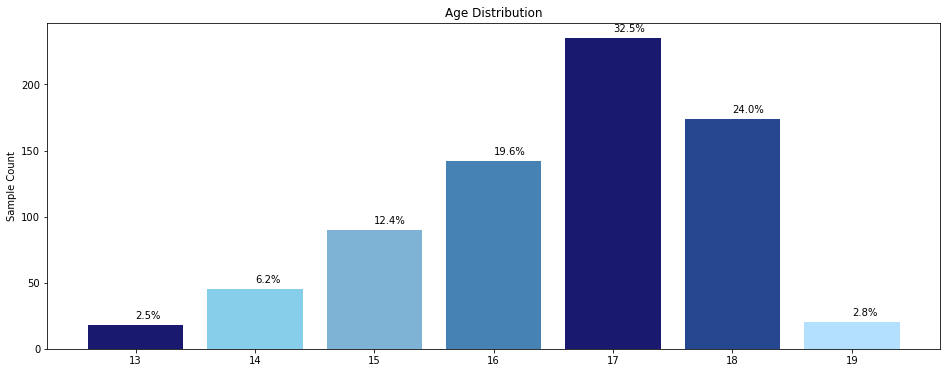

In [7]:
#Bar plot for Age
pretty_bar(demos_df['Age'],(16,6),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Age Distribution')
plt.ylabel('Sample Count')
plt.show()

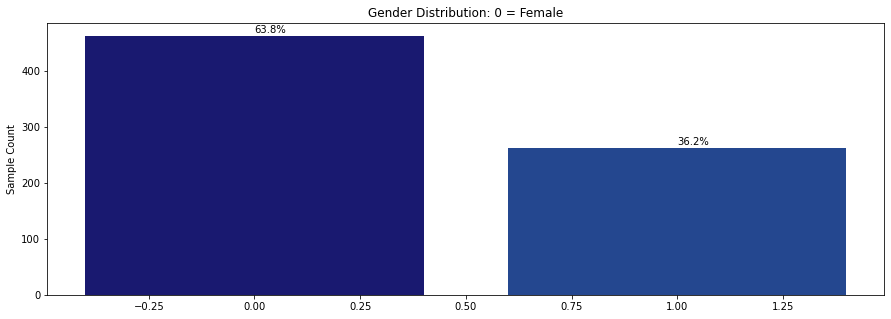

In [8]:
#Bar plot for Gender
pretty_bar(demos_df['Female'],(15,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Gender Distribution: 0 = Female')
plt.ylabel('Sample Count')
plt.show()

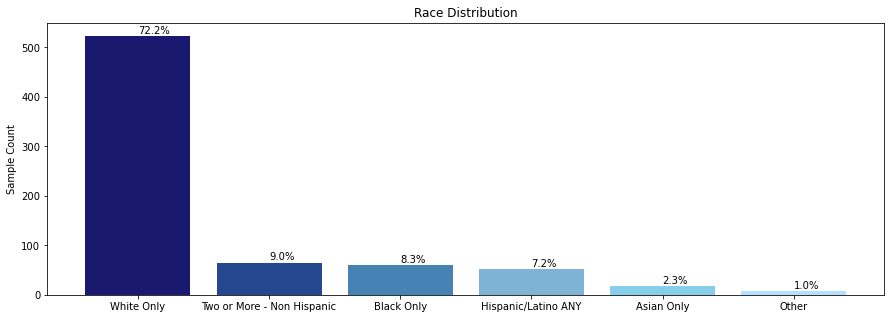

In [9]:
#Bar plot for Race
pretty_bar(demos_df['Race'],(15,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Race Distribution')
plt.ylabel('Sample Count')
plt.show()

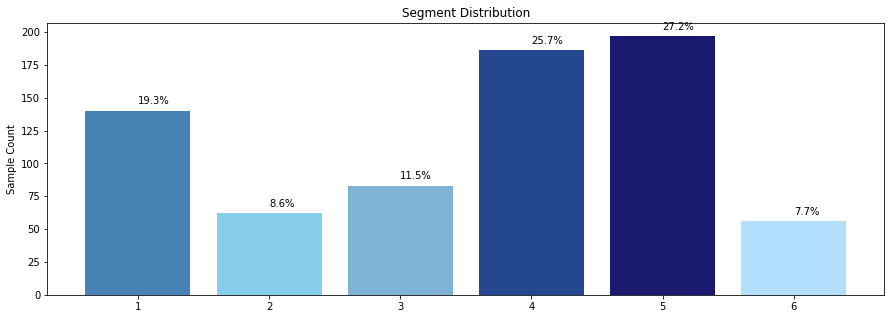

In [10]:
#Bar plot for Segment
pretty_bar(demos_df['Segment'],(15,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Segment Distribution')
plt.ylabel('Sample Count')
plt.show()

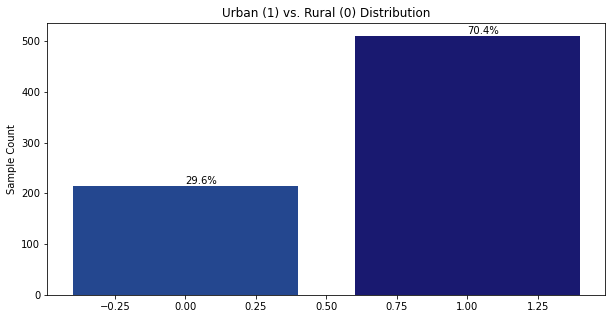

In [11]:
#Bar plot for Urban
pretty_bar(demos_df['Urban'],(10,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Urban (1) vs. Rural (0) Distribution')
plt.ylabel('Sample Count')
plt.show()

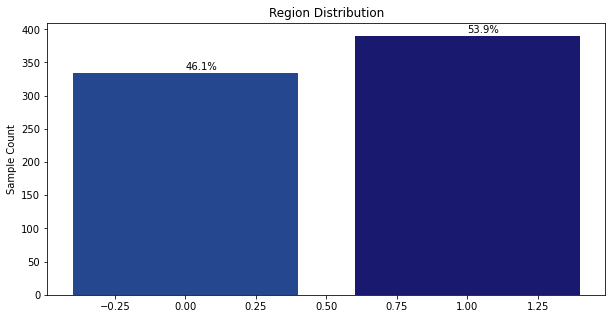

In [12]:
#Bar plot for Region_1
pretty_bar(demos_df['Region_1'],(10,5),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Region Distribution')
plt.ylabel('Sample Count')
plt.show()

### Step 3: Tokenize & Remove Stopwords <a class="anchor" id="3"></a>
Source: Adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.

* Selected spacy for tokenization over nltk for its ability to 'construct a syntactic tree' which 'yields much more information about the text.' -- According to: https://medium.com/@akankshamalhotra24/introduction-to-libraries-of-nlp-in-python-nltk-vs-spacy-42d7b2f128f2#:~:text=NLTK%20is%20a%20string%20processing%20library.&text=As%20spaCy%20uses%20the%20latest,sentence%20tokenization%2C%20NLTK%20outperforms%20spaCy
<br><br>
* For now, we'll just apply basic tokenization & lemmatization for EDA of term frequency

In [13]:
# Load spacy
nlp = en_core_web_sm.load()

In [14]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


#Not adding custom stopwords right now -- just initial check
'''#Custom stopwords
custom_stopwords = ['']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)
'''
STOP_WORDS = nlp.Defaults.stop_words

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)

tokens = []

for doc in tokenizer.pipe(clean_df['Text_Clean'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in stopwords:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column

clean_df['tokens'] = tokens
clean_df.head()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,tokens
0,R_31EnmC82PmXgfeJ,A lot of chemicals are in vapes that damage th...,DF,17,White Only,1,1,0,1,a lot of chemicals are in vapes that damage th...,"[lot, chemicals, vapes, damage, lungs, make, s..."
1,R_2UVKzhgLoqvkyzk,A method of discouragement against vaping by i...,DD,18,White Only,4,0,0,0,a method of discouragement against vaping by i...,"[method, discouragement, vaping, intending, ma..."
2,R_2PC3MSRmAF3ln2c,About the ingredients in vape,ST,18,White Only,1,1,1,0,about the ingredients in vape,"[ingredients, vape]"
3,R_2X1neYEGvSteyEY,about the stuff that's in the vape juice,ST,17,White Only,5,1,1,0,about the stuff that is in the vape juice,"[stuff, vape, juice]"
4,R_2rMIp9IjjI6Mzpi,Ads at vape stores are misleading. It makes yo...,ST,18,Two or More - Non Hispanic,4,1,1,0,ads at vape stores are misleading it makes yo...,"[ads, vape, stores, misleading, , makes, want..."


### Step 4: Lemmatize <a class="anchor" id="4"></a>
Source: Adapted from a Towards Data Science article posted by Amin Azad at https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2, retrieved in January 2021.
* Using spaCy here as well determines the part-of-speech tag by default and assigns the corresponding lemma.

In [15]:
#Make tokens a string again
clean_df['tokens_string'] = [' '.join(map(str, l)) for l in clean_df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

clean_df['lemmas'] = clean_df['tokens_string'].apply(get_lemmas)

In [16]:
# Make lemmas a string again
clean_df['lem_text'] = [' '.join(map(str, l)) for l in clean_df['lemmas']]

#Delete extra vars, just keep tokenized lemmas and lematized text
clean_df = clean_df.drop(columns = ['tokens','tokens_string'])
clean_df = clean_df.rename(columns = {'lemmas':'Text_Token', 'lem_text':'Text_Lemmas'})

In [17]:
#Check results
clean_df = clean_df.sort_values(by='Text_Lemmas')
clean_df.head()

,ID,Text_Original,Ad,Age,Race,Segment,Urban,Female,Region_1,Text_Clean,Text_Token,Text_Lemmas
89,R_3M6w5RK9ZUNrdUo,Don’t do it,ST,14,White Only,5,0,1,0,do not do it,[],
382,R_V2yNrEUwutvpby1,nothing,DF,18,Black Only,3,1,1,0,nothing,[],
1441,R_6nF1JdvsUBwcWzf,You’re being used,DD,17,White Only,2,1,1,0,you are being used,[],
416,R_3efvb3lV5XL04VO,Same as the last,ST,17,White Only,3,1,0,1,same as the last,[],
234,R_1DYa4Yf8yUgePAi,I like it,ST,19,White Only,5,1,0,0,i like it,[],


#### Notes:
* Potential words to add to stopwords list for processing:
    * 'vape' as this is very frequent

### Step 5: Text Frequency Analysis<a class="anchor" id="5"></a>
Source: Term Frequency Analysis and WordCloud code adapted from Towards Data Science article by Kamil Mysiak at https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d retrieved in January, 2021.

#### Main Message Feedback Text Frequency

In [18]:
#Create word list
words = clean_df['Text_Token']
allwords = []
for wordlist in words:
    allwords += wordlist

In [20]:
#Inspect and edit word list to remove any stopwords or punctuation missed in cleaning
FreqDist(allwords).most_common(100)

[('vape', 1078),
 ('company', 204),
 ('  ', 154),
 ('virus', 144),
 ('people', 127),
 ('stop', 126),
 ('teen', 126),
 ('bad', 121),
 ('smoke', 114),
 ('lie', 104),
 ('body', 102),
 ('lung', 99),
 ('harmful', 97),
 ('system', 89),
 ('immune', 85),
 ('make', 81),
 ('chemical', 77),
 ('target', 70),
 ('damage', 64),
 ('juul', 63),
 ('vaping', 61),
 ('health', 56),
 ('sick', 51),
 ('product', 48),
 ('harm', 48),
 ('dangerous', 47),
 ('young', 46),
 ('susceptible', 46),
 ('try', 44),
 ('know', 42),
 ('risk', 42),
 ('weaken', 41),
 ('vulnerable', 40),
 ('fight', 37),
 ('safe', 35),
 ('kid', 34),
 ('disease', 32),
 ('break', 31),
 ('inform', 30),
 ('s', 30),
 ('tell', 27),
 ('addict', 27),
 ('ability', 27),
 ('message', 25),
 ('likely', 25),
 ('quit', 25),
 ('main', 24),
 ('get', 23),
 ('effect', 23),
 ('smoking', 23),
 ('cause', 22),
 ('truth', 22),
 ('customer', 22),
 ('easy', 22),
 ('think', 22),
 ('infection', 21),
 ('good', 19),
 ('covid', 19),
 ('thing', 18),
 ('weak', 17),
 ('addicted'

In [22]:
#Edit list - remove blanks and just 's' for frequency analysis
words = clean_df['Text_Token']
allwords = []
for wordlist in words:
    if "  " not in wordlist and "s" not in wordlist:
        allwords += wordlist

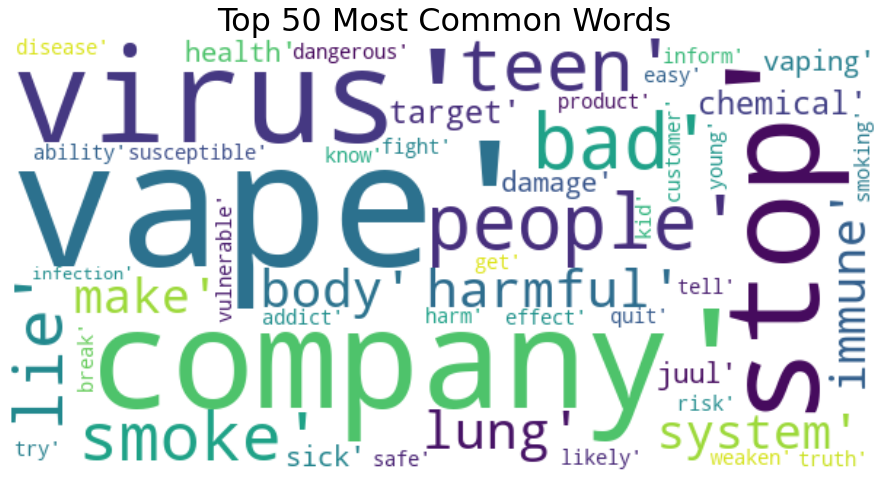

In [24]:
#Create word cloud
mostcommon = FreqDist(allwords).most_common(50)
wordcloud = WordCloud(width=600, height=300,
background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(20,6.5), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Words', fontsize=32)
plt.tight_layout(pad=0)
plt.show()

In [25]:
#Create function for word frequency bar plots

def word_bar(x,y,figsize,colors):
    #Loop below creates the percentage labels
    y_percents = []
    for i in y:
        y_percents.append((round((i / (np.sum(y))) *100,1)))
    
    y_perlabs = []
    for i in y_percents: 
        y_perlabs.append(str(i)+'%')
    y_perlabs = np.array(y_perlabs)
    
    x = x
    
    plt.subplots(figsize=figsize)
    plt.bar(x, y, align='center', color=colors) #actual bar plot setup
    plt.xticks(rotation=60)


    # Text on the top of each bar, 
    # Code for below adapted from https://www.python-graph-gallery.com/10-barplot-with-number-of-observation
    for i in range(len(x)):
        plt.text(x = x[i] , y = y[i]+0.5, s=y_perlabs[i])

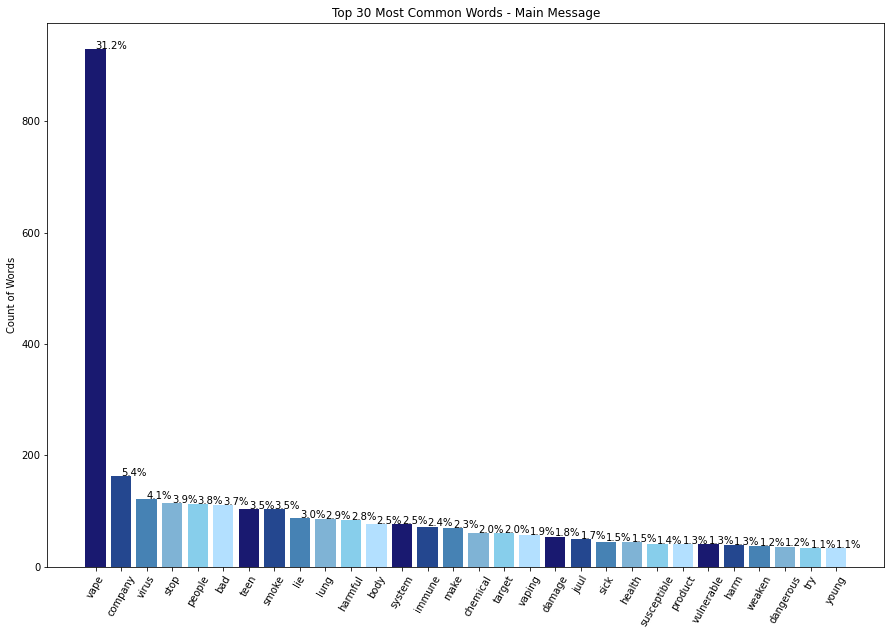

In [28]:
mostcommon_small = FreqDist(allwords).most_common(30)
x, y = zip(*mostcommon_small)
        
word_bar(x,y,(15,10),color_palette)
plt.style.use('seaborn-colorblind')
plt.title('Top 30 Most Common Words - Main Message')
plt.ylabel('Count of Words')
plt.show()

#### Notes:
* Ad video messages related to:
    * chemicals in vapes
    * vapes making smokers vulnerable to viruses/illness
    * vape companies deceiving teens
* Most common words in response to main message include:
    * vape - likely related to all -- might exclude in processing
    * company, teen, people
    * chemical, harmful, lung
    * virus, immune

### Step 6: Sentiment Analysis <a class="anchor" id="6"></a>
Source: Sentiment Analysis code adapted from Towards Data Science article by Kamil Mysiak at https://towardsdatascience.com/nlp-part-3-exploratory-data-analysis-of-text-data-1caa8ab3f79d retrieved in January, 2021.
* Sentiment analysis is used to measure the sentiment in text ranging from -1 (negative sentiment) to 1 (positive sentiment).

#### Sentiment Analysis of 'Likes' Feedback

In [30]:
clean_df['sentiment'] = clean_df['Text_Lemmas'].apply(lambda x:
TextBlob(x).sentiment.polarity)
clean_df = clean_df.sort_values(by='sentiment', ascending=False)

In [31]:
#Average sentiment score for 'Likes'
np.mean(clean_df['sentiment'])

-0.08007460277790061

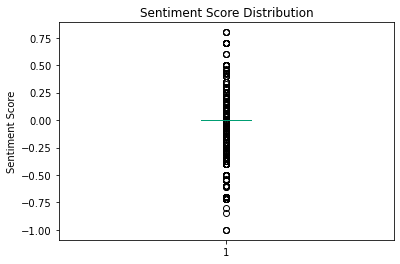

In [33]:
#View distribution box plot
plt.boxplot(clean_df['sentiment'])
plt.title('Sentiment Score Distribution')
plt.ylabel('Sentiment Score')
plt.show()

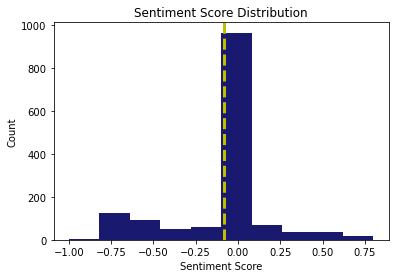

In [64]:
#View distribution histogram
plt.hist(clean_df['sentiment'], color='midnightblue')
plt.axvline(clean_df['sentiment'].mean(), color='y', linestyle='dashed', linewidth=3)

plt.style.use('seaborn-colorblind')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

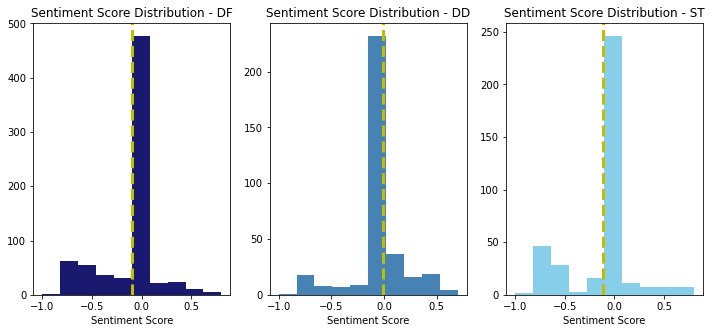

In [63]:
#Sentiment score by ad

plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
plt.hist(clean_df[clean_df['Ad']=='DF']['sentiment'], color='midnightblue')
plt.axvline(clean_df[clean_df['Ad']=='DF']['sentiment'].mean(), color='y', linestyle='dashed', linewidth=3)
plt.style.use('seaborn-colorblind')
plt.title('Sentiment Score Distribution - DF')
plt.xlabel('Sentiment Score')

plt.subplot(1,3,2)
plt.hist(clean_df[clean_df['Ad']=='DD']['sentiment'], color='steelblue')
plt.axvline(clean_df[clean_df['Ad']=='DD']['sentiment'].mean(), color='y', linestyle='dashed', linewidth=3)
plt.style.use('seaborn-colorblind')
plt.title('Sentiment Score Distribution - DD')
plt.xlabel('Sentiment Score')

plt.subplot(1,3,3)
plt.hist(clean_df[clean_df['Ad']=='ST']['sentiment'], color='skyblue')
plt.axvline(clean_df[clean_df['Ad']=='ST']['sentiment'].mean(), color='y', linestyle='dashed', linewidth=3)
plt.style.use('seaborn-colorblind')
plt.title('Sentiment Score Distribution - ST')
plt.xlabel('Sentiment Score')
plt.show()

#### Notes:
* Overall sentiment is mostly neutral but with a negative skew.
* Sentiment by ad is highest for DD, on average, although all have mostly neutral sentiment.
* The ad messages themselves may actually be driving the negative skew and they are related to deception and the harms of vaping.

### Step 7: Summary & Next Steps <a class="anchor" id="7"></a>

#### Sample Summary:
* n=724 survey participants
* Participant age range from 13-19, with an average age of 16.7 years, and median age of 17 years.
* The sample is skewed toward females at 64% and White/Caucasian participants at 72.2% (although this somewhat reflects the regional race distribution).
* The most highly represented target audience segments are segments 1, 4, and 5, making up nearly 50% of the sample.
* In terms participant location, nearly 3/4 live in an urban area, and the regional distribution is fairly event at 46% vs. 54%.

#### Text Frequency Analysis Summary:
* The most commonly used words used in explaining the message of the ads included vape, company, virus, stop, people, bad, teen, smoke, lie, lung, and harmful which relate well to the ad themes of chemicals in vapes, vulnerability to viruses and illnesses from vaping, and deception by vape companies.

#### Sentiment Analysis Summary:
* The overall sentiment of text feedback is mostly neutral at 0, however, there is a negative skew, particularly for DF and ST.

#### Next Steps:
* The EDA of the ad feedback text was conducted using a combination of space, gensim, and word cloud stopwords. For preprocessing, it may help to make some updates to the stop words list.
    * Consider adding ’vape’ to the stop words list as it is related to all and commonly used.
* While the sentiment analysis can be helpful in ad feedback, it does not appear to be appropriate for responses regarding the main message of the ad. If the question was more vague like ‘What did you think of this ad?’, it might be more valuable.